In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("../data/raw/crypto_hourly_data.csv")

# Convert datetime
if 'timestamp' in df.columns:
    df['datetime'] = pd.to_datetime(df['timestamp'])
elif 'date' in df.columns and 'time' in df.columns:
    df['datetime'] = pd.to_datetime(df['date'] + " " + df['time'])
else:
    raise ValueError("Không tìm thấy timestamp hoặc date/time")

# Sort + set index
df = df.sort_values('datetime')
df = df.set_index('datetime')

# FIX duplicate datetime
df = df[~df.index.duplicated(keep='first')]

# Convert số
num_cols = ['open','high','low','close','volume','quote_volume',
            'taker_buy_base_volume','taker_buy_quote_volume']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.head()


,open,high,low,close,volume,quote_volume,trades_count,taker_buy_base_volume,taker_buy_quote_volume,timestamp,date,time,symbol,interval
datetime,,,,,,,,,,,,,,
2025-10-21 23:00:00,109066.9800,109423.1900,108045.8100,108297.6700,1.531007e+03,1.664970e+08,301894,6.009483e+02,6.533803e+07,2025-10-21 23:00:00,2025-10-21,23:00:00,BTCUSDT,1h
2025-10-22 00:00:00,92.4500,92.8800,91.9500,92.3900,4.082702e+04,3.773372e+06,23205,1.538559e+04,1.421858e+06,2025-10-22 00:00:00,2025-10-22,00:00:00,LTCUSDT,1h
2025-10-22 01:00:00,4080.0700,4122.4800,4067.7300,4089.6200,1.333119e+03,5.468886e+06,19128,6.276702e+02,2.574937e+06,2025-10-22 01:00:00,2025-10-22,01:00:00,PAXGUSDT,1h
2025-10-22 02:00:00,2.4247,2.4326,2.4215,2.4236,2.912694e+06,7.066564e+06,28501,1.727951e+06,4.192300e+06,2025-10-22 02:00:00,2025-10-22,02:00:00,XRPUSDT,1h
2025-10-22 03:00:00,2.4236,2.4237,2.4088,2.4201,3.881306e+06,9.376644e+06,32162,1.953708e+06,4.720081e+06,2025-10-22 03:00:00,2025-10-22,03:00:00,XRPUSDT,1h


Câu hỏi 1 – Volume có ảnh hưởng đến biến động giá không?
Vì sao câu hỏi này hay?
Volume là feature quan trọng nhất trong thị trường crypto.

Nếu volume ↑ → giá biến động mạnh → mô hình dự đoán tốt hơn

Correlation giữa Volume và Biến động giá: -0.006057451284738871


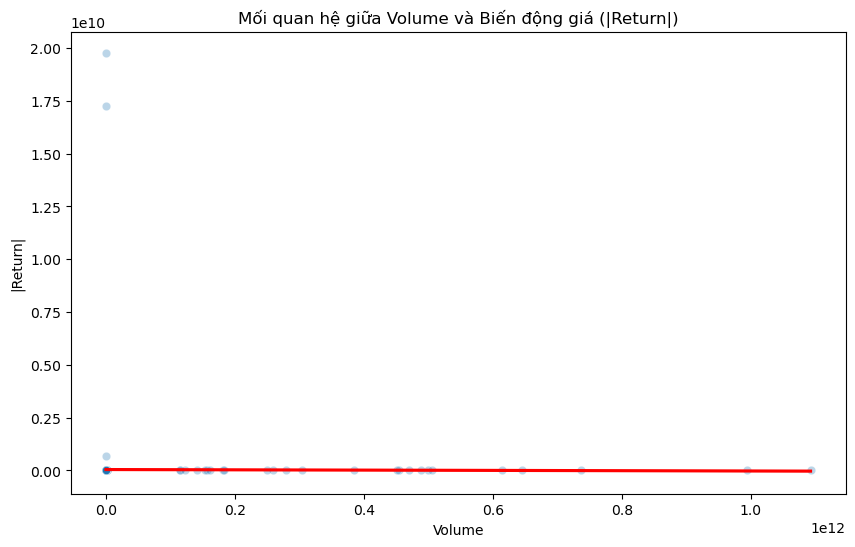

In [5]:
# Tính price return
df['return'] = df['close'].pct_change()
df['abs_return'] = df['return'].abs()

# Correlation
corr_q1 = df[['volume', 'abs_return']].corr().iloc[0,1]
print("Correlation giữa Volume và Biến động giá:", corr_q1)

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='volume', y='abs_return', alpha=0.3)
sns.regplot(data=df, x='volume', y='abs_return', scatter=False, color='red')

plt.title("Mối quan hệ giữa Volume và Biến động giá (|Return|)")
plt.xlabel("Volume")
plt.ylabel("|Return|")
plt.show()


Câu hỏi 2 – Taker Buy Volume có dự báo xu hướng giá không?
Câu hỏi
Taker Buy Quote Volume tăng có đi kèm với xu hướng giá tăng hay không?

Vì sao câu hỏi này hay?
Taker buy = lực mua chủ động.

Khi tăng mạnh → thị trường bullish

Đây là tín hiệu vi mô (market microstructure) → thầy/cô đánh giá rất cao.

Có thể kết hợp trong model dự đoán sau này.



Correlation giữa Taker Buy Quote Volume và Price Return: 0.027022229435016313


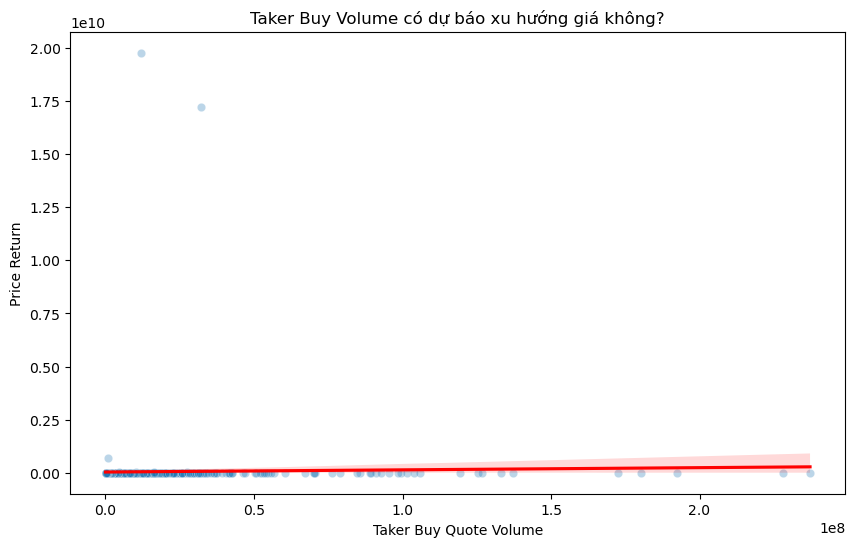

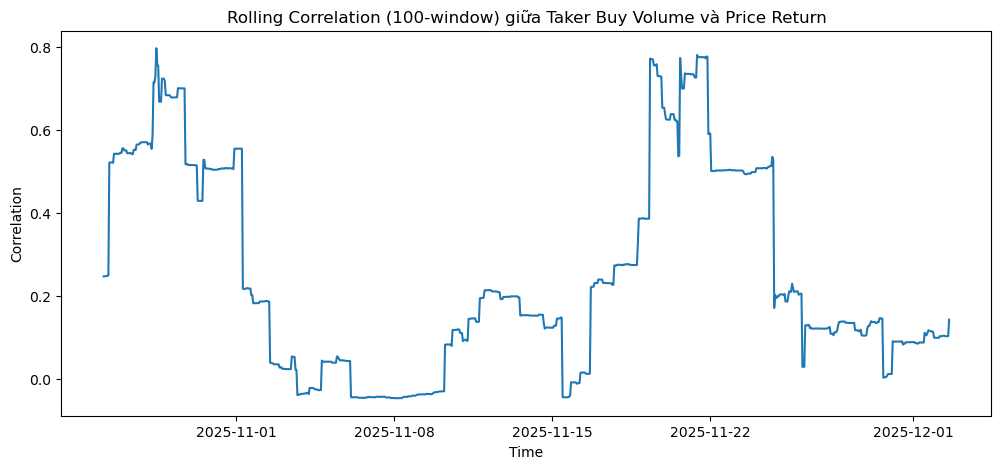

In [6]:
# Tính price return cho xu hướng giá
df['price_return'] = df['close'].pct_change()

# Correlation
corr_q2 = df[['taker_buy_quote_volume', 'price_return']].corr().iloc[0,1]
print("Correlation giữa Taker Buy Quote Volume và Price Return:", corr_q2)

# Plot scatter
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='taker_buy_quote_volume', y='price_return', alpha=0.3)
sns.regplot(data=df, x='taker_buy_quote_volume', y='price_return', scatter=False, color='red')

plt.title("Taker Buy Volume có dự báo xu hướng giá không?")
plt.xlabel("Taker Buy Quote Volume")
plt.ylabel("Price Return")
plt.show()

# Rolling correlation
df['rolling_corr'] = df['taker_buy_quote_volume'].rolling(100).corr(df['price_return'])

plt.figure(figsize=(12,5))
plt.plot(df['rolling_corr'])
plt.title("Rolling Correlation (100-window) giữa Taker Buy Volume và Price Return")
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.show()
